In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, adjusted_rand_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

# Set plot style
sns.set(style='whitegrid')

## 1. Load and Inspect the dataset

In [53]:
# Load dataset
data = pd.read_csv("teen_phone_addiction_dataset.csv")

# View shape and first few rows
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (3000, 25)


,ID,Name,Age,Gender,Location,School_Grade,Daily_Usage_Hours,Sleep_Hours,Academic_Performance,Social_Interactions,...,Screen_Time_Before_Bed,Phone_Checks_Per_Day,Apps_Used_Daily,Time_on_Social_Media,Time_on_Gaming,Time_on_Education,Phone_Usage_Purpose,Family_Communication,Weekend_Usage_Hours,Addiction_Level
0,1,Shannon Francis,13,Female,Hansonfort,9th,4.0,6.1,78,5,...,1.4,86,19,3.6,1.7,1.2,Browsing,4,8.7,10.0
1,2,Scott Rodriguez,17,Female,Theodorefort,7th,5.5,6.5,70,5,...,0.9,96,9,1.1,4.0,1.8,Browsing,2,5.3,10.0
2,3,Adrian Knox,13,Other,Lindseystad,11th,5.8,5.5,93,8,...,0.5,137,8,0.3,1.5,0.4,Education,6,5.7,9.2
3,4,Brittany Hamilton,18,Female,West Anthony,12th,3.1,3.9,78,8,...,1.4,128,7,3.1,1.6,0.8,Social Media,8,3.0,9.8
4,5,Steven Smith,14,Other,Port Lindsaystad,9th,2.5,6.7,56,4,...,1.0,96,20,2.6,0.9,1.1,Gaming,10,3.7,8.6


## 2.1 Data cleaning 

In [54]:
# Drop rows with missing values
data.dropna(inplace=True)


# Convert Addiction_Level into binary classification
# Addiction scores > 7.0 are labeled as 'High' (1), otherwise 'Low' (0)

data["Addiction_Binary"] = data["Addiction_Level"].apply(lambda x: 1 if x > 7.0 else 0)
data.head()

,ID,Name,Age,Gender,Location,School_Grade,Daily_Usage_Hours,Sleep_Hours,Academic_Performance,Social_Interactions,...,Phone_Checks_Per_Day,Apps_Used_Daily,Time_on_Social_Media,Time_on_Gaming,Time_on_Education,Phone_Usage_Purpose,Family_Communication,Weekend_Usage_Hours,Addiction_Level,Addiction_Binary
0,1,Shannon Francis,13,Female,Hansonfort,9th,4.0,6.1,78,5,...,86,19,3.6,1.7,1.2,Browsing,4,8.7,10.0,1
1,2,Scott Rodriguez,17,Female,Theodorefort,7th,5.5,6.5,70,5,...,96,9,1.1,4.0,1.8,Browsing,2,5.3,10.0,1
2,3,Adrian Knox,13,Other,Lindseystad,11th,5.8,5.5,93,8,...,137,8,0.3,1.5,0.4,Education,6,5.7,9.2,1
3,4,Brittany Hamilton,18,Female,West Anthony,12th,3.1,3.9,78,8,...,128,7,3.1,1.6,0.8,Social Media,8,3.0,9.8,1
4,5,Steven Smith,14,Other,Port Lindsaystad,9th,2.5,6.7,56,4,...,96,20,2.6,0.9,1.1,Gaming,10,3.7,8.6,1


## 2.2. Descriptive Statistics

In [55]:
# Summary of numerical features
data.describe()

,ID,Age,Daily_Usage_Hours,Sleep_Hours,Academic_Performance,Social_Interactions,Exercise_Hours,Anxiety_Level,Depression_Level,Self_Esteem,...,Screen_Time_Before_Bed,Phone_Checks_Per_Day,Apps_Used_Daily,Time_on_Social_Media,Time_on_Gaming,Time_on_Education,Family_Communication,Weekend_Usage_Hours,Addiction_Level,Addiction_Binary
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,...,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,1500.500000,15.969667,5.020667,6.489767,74.947333,5.097667,1.040667,5.590000,5.460333,5.546333,...,1.006733,83.093000,12.609333,2.499233,1.525267,1.016333,5.459667,6.015100,8.881900,0.851333
std,866.169729,1.989489,1.956501,1.490713,14.684156,3.139333,0.734620,2.890678,2.871557,2.860754,...,0.492878,37.747044,4.611486,0.988201,0.932701,0.648341,2.864572,2.014776,1.609598,0.355819
min,1.000000,13.000000,0.000000,3.000000,50.000000,0.000000,0.000000,1.000000,1.000000,1.000000,...,0.000000,20.000000,5.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
25%,750.750000,14.000000,3.700000,5.500000,62.000000,2.000000,0.500000,3.000000,3.000000,3.000000,...,0.700000,51.000000,9.000000,1.800000,0.800000,0.500000,3.000000,4.700000,8.000000,1.000000
50%,1500.500000,16.000000,5.000000,6.500000,75.000000,5.000000,1.000000,6.000000,5.000000,6.000000,...,1.000000,82.000000,13.000000,2.500000,1.500000,1.000000,5.000000,6.000000,10.000000,1.000000
75%,2250.250000,18.000000,6.400000,7.500000,88.000000,8.000000,1.500000,8.000000,8.000000,8.000000,...,1.400000,115.250000,17.000000,3.200000,2.200000,1.500000,8.000000,7.400000,10.000000,1.000000
max,3000.000000,19.000000,11.500000,10.000000,100.000000,10.000000,4.000000,10.000000,10.000000,10.000000,...,2.600000,150.000000,20.000000,5.000000,4.000000,3.000000,10.000000,14.000000,10.000000,1.000000


In [56]:
# Check data types
data.dtypes

ID                          int64
Name                       object
Age                         int64
Gender                     object
Location                   object
School_Grade               object
Daily_Usage_Hours         float64
Sleep_Hours               float64
Academic_Performance        int64
Social_Interactions         int64
Exercise_Hours            float64
Anxiety_Level               int64
Depression_Level            int64
Self_Esteem                 int64
Parental_Control            int64
Screen_Time_Before_Bed    float64
Phone_Checks_Per_Day        int64
Apps_Used_Daily             int64
Time_on_Social_Media      float64
Time_on_Gaming            float64
Time_on_Education         float64
Phone_Usage_Purpose        object
Family_Communication        int64
Weekend_Usage_Hours       float64
Addiction_Level           float64
Addiction_Binary            int64
dtype: object

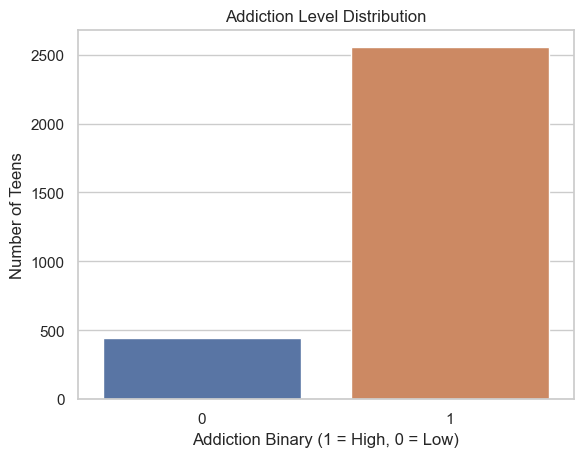

Addiction_Binary
1    2554
0     446
Name: count, dtype: int64


In [57]:
# Check distribution of the target variable
sns.countplot(x="Addiction_Binary", data=data)
plt.title("Addiction Level Distribution")
plt.xlabel("Addiction Binary (1 = High, 0 = Low)")
plt.ylabel("Number of Teens")
plt.show()

# Display value counts
print(data["Addiction_Binary"].value_counts())

## 2.3 Univariate Visualizations

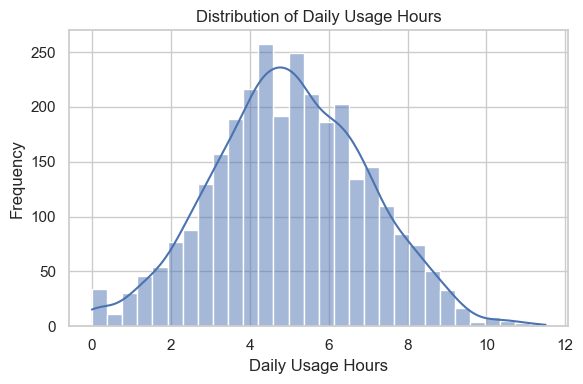

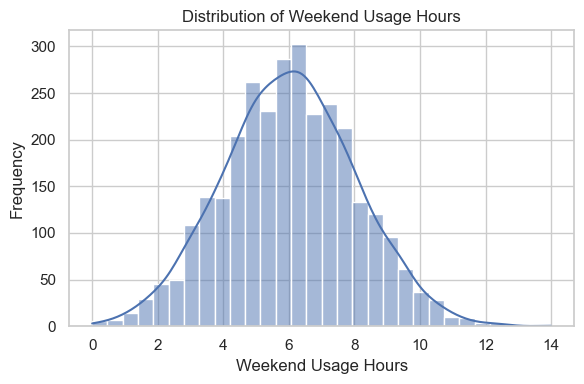

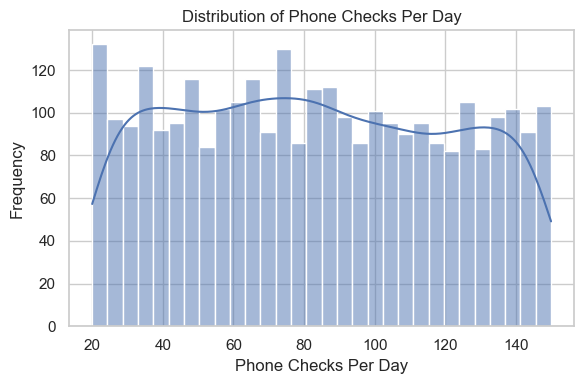

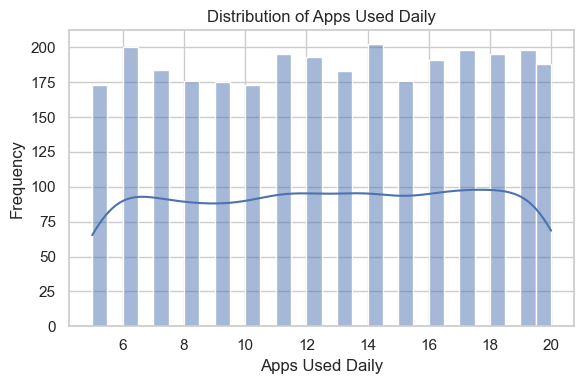

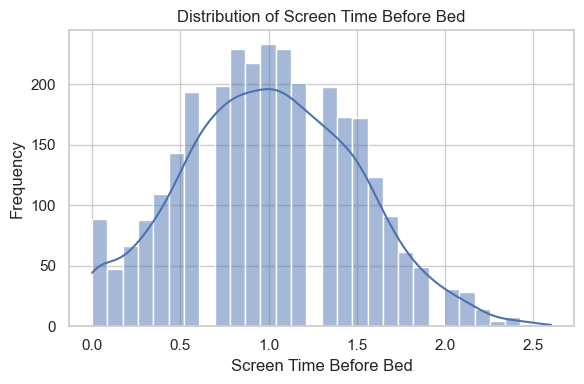

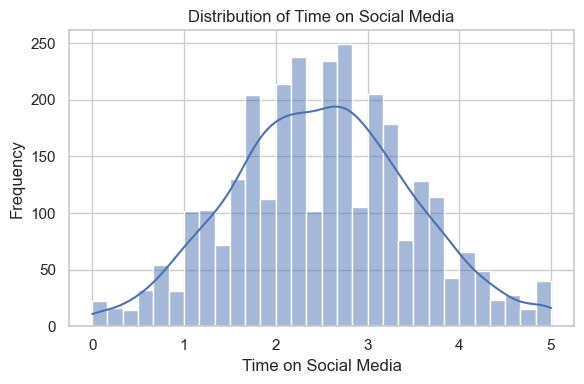

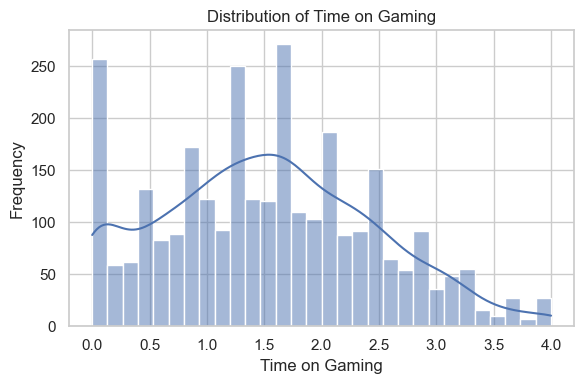

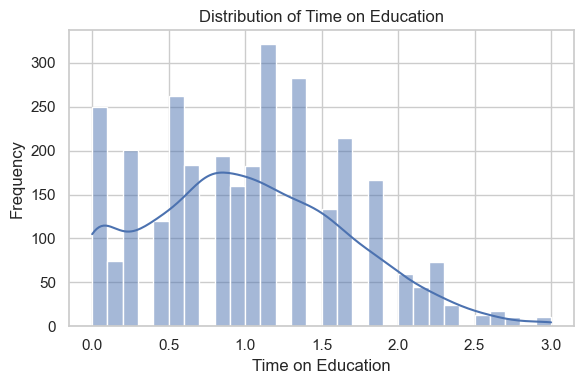

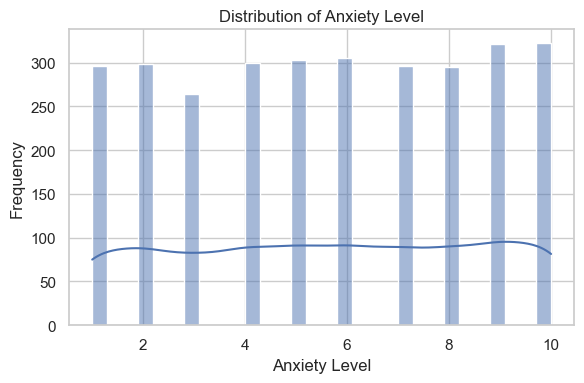

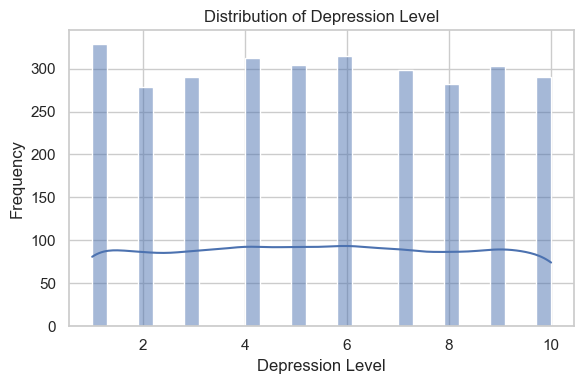

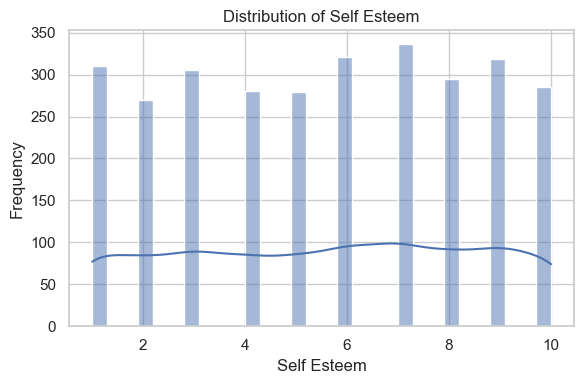

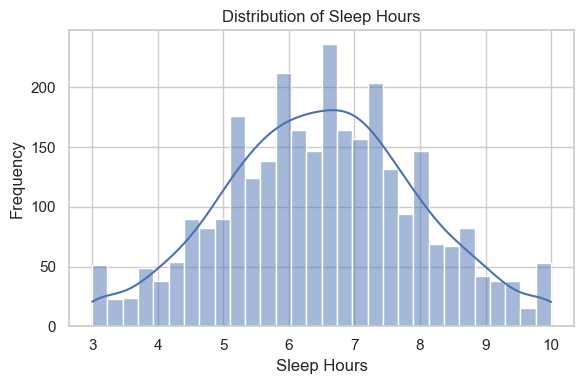

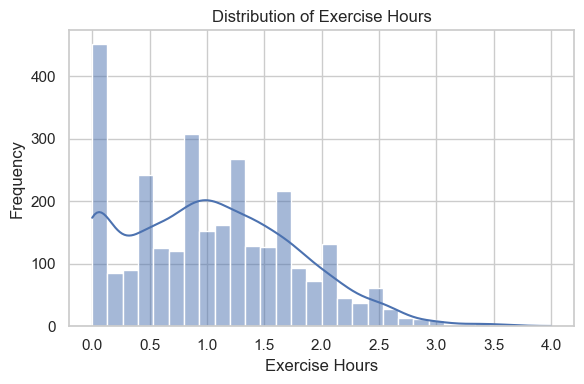

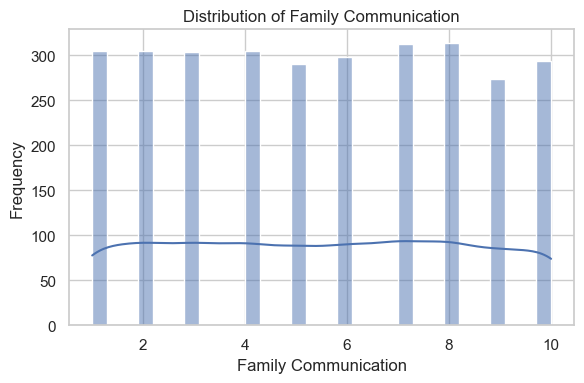

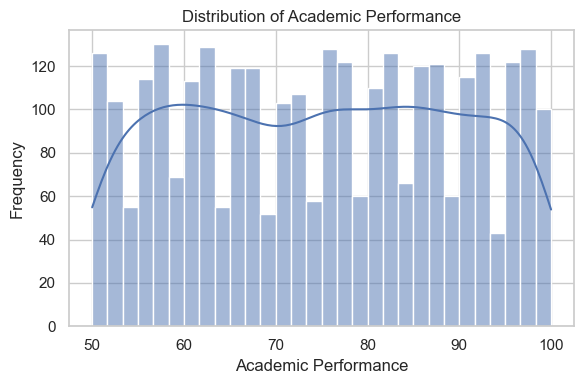

In [58]:
# List of features to plot
usage_features = [
    "Daily_Usage_Hours", "Weekend_Usage_Hours", "Phone_Checks_Per_Day",
    "Apps_Used_Daily", "Screen_Time_Before_Bed", "Time_on_Social_Media",
    "Time_on_Gaming", "Time_on_Education"
]

mental_health_features = ["Anxiety_Level", "Depression_Level", "Self_Esteem"]
lifestyle_features = ["Sleep_Hours", "Exercise_Hours", "Family_Communication"]
academic_feature = ["Academic_Performance"]

# Plot numeric feature distributions
all_features = usage_features + mental_health_features + lifestyle_features + academic_feature

for col in all_features:
    plt.figure(figsize=(6, 4))
    sns.histplot(data[col], bins=30, kde=True)
    plt.title(f"Distribution of {col.replace('_', ' ')}")
    plt.xlabel(col.replace('_', ' '))
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()



## 2.4 Bivariate Analysis & Statistical Testing

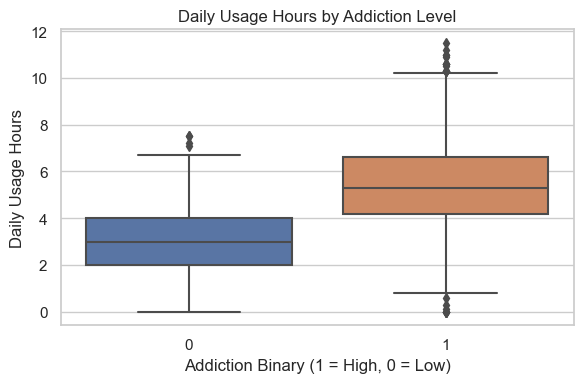

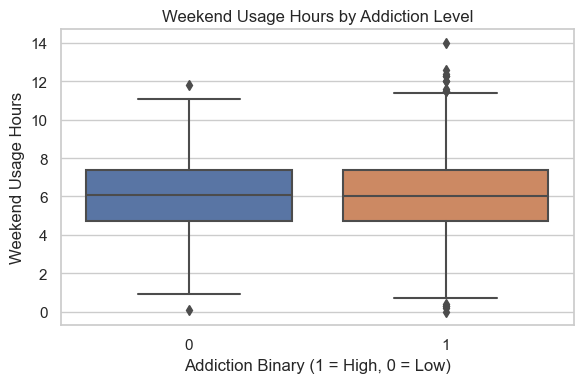

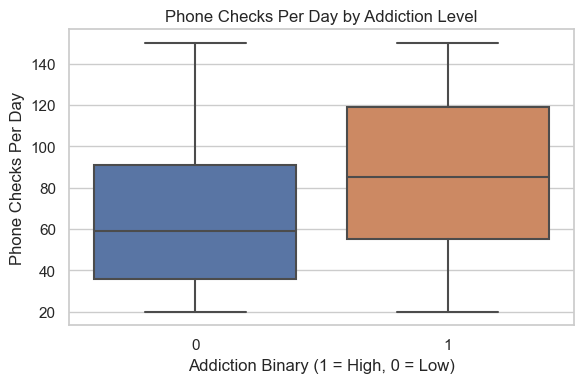

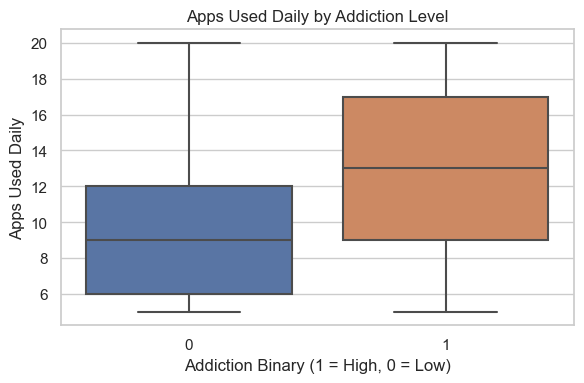

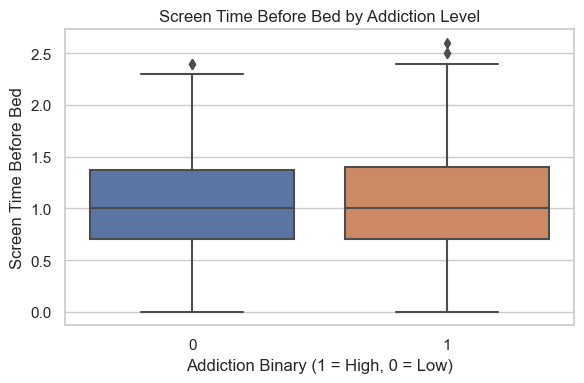

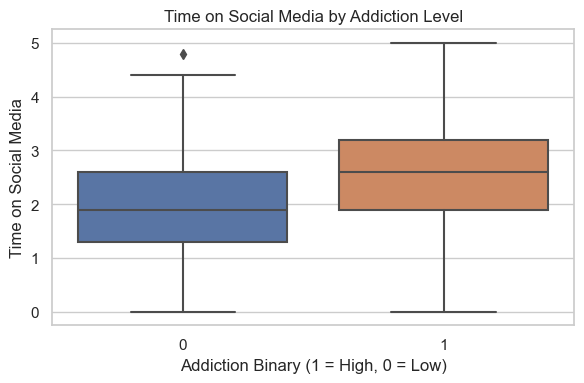

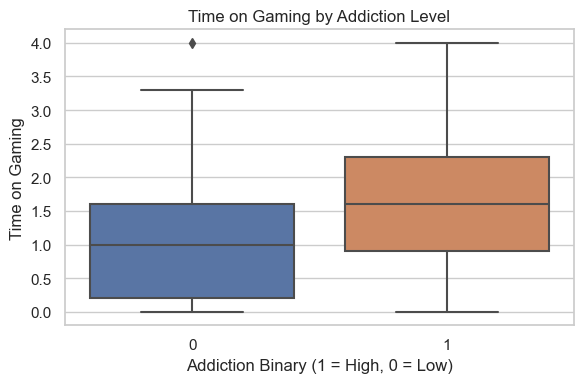

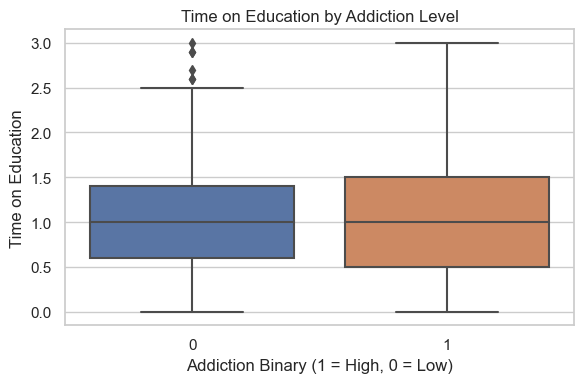

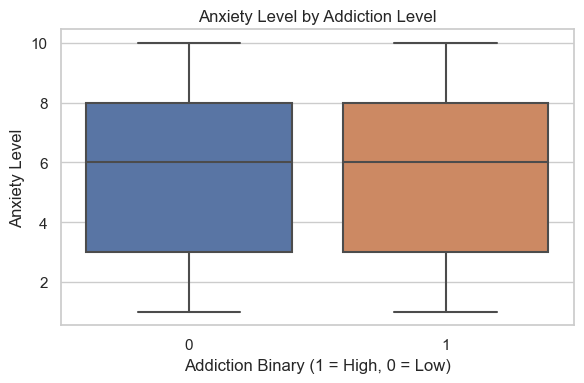

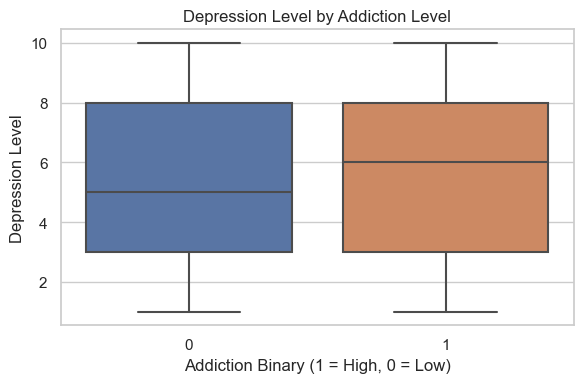

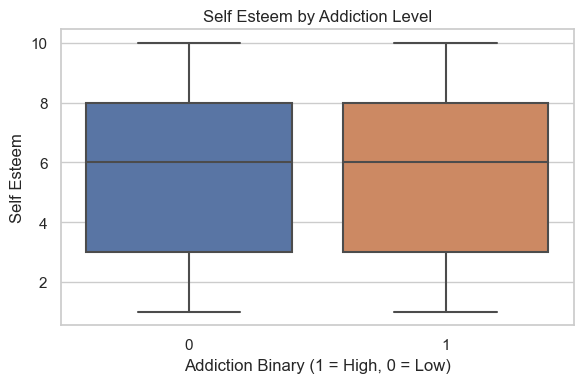

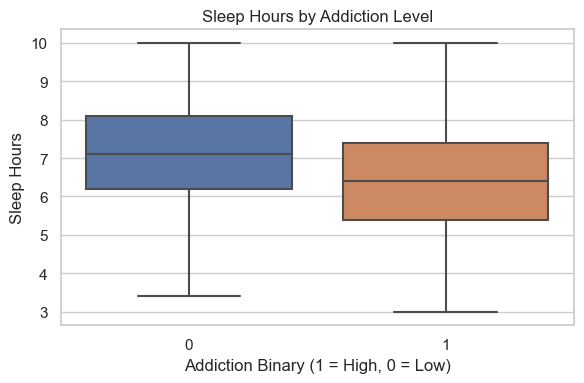

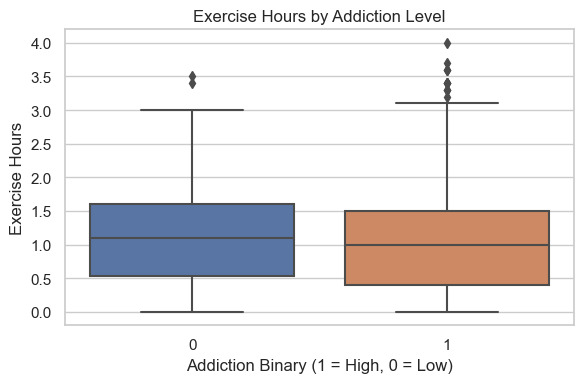

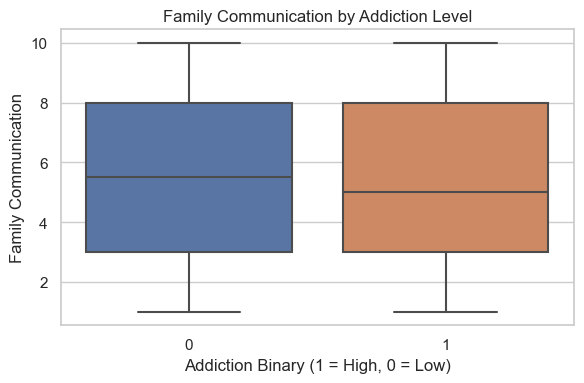

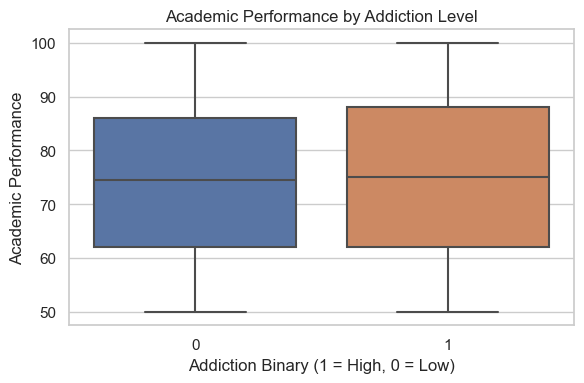

In [59]:
# Box plot by addiction Binary

for col in all_features:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x="Addiction_Binary", y=col, data=data)
    plt.title(f"{col.replace('_', ' ')} by Addiction Level")
    plt.xlabel("Addiction Binary (1 = High, 0 = Low)")
    plt.ylabel(col.replace('_', ' '))
    plt.tight_layout()
    plt.show()


In [60]:
# T-Tests

# Split data by addiction level
high = data[data["Addiction_Binary"] == 1]
low = data[data["Addiction_Binary"] == 0]

# Run t-tests
from scipy.stats import ttest_ind

print("T-test Results:\n")
for col in all_features:
    t_stat, p_val = ttest_ind(high[col], low[col])
    print(f"{col}: t-stat = {t_stat:.3f}, p-value = {p_val:.5f}")

T-test Results:

Daily_Usage_Hours: t-stat = 26.349, p-value = 0.00000
Weekend_Usage_Hours: t-stat = -0.542, p-value = 0.58813
Phone_Checks_Per_Day: t-stat = 10.493, p-value = 0.00000
Apps_Used_Daily: t-stat = 14.144, p-value = 0.00000
Screen_Time_Before_Bed: t-stat = -0.083, p-value = 0.93389
Time_on_Social_Media: t-stat = 13.105, p-value = 0.00000
Time_on_Gaming: t-stat = 12.438, p-value = 0.00000
Time_on_Education: t-stat = -0.278, p-value = 0.78087
Anxiety_Level: t-stat = 0.961, p-value = 0.33655
Depression_Level: t-stat = 1.167, p-value = 0.24320
Self_Esteem: t-stat = -1.423, p-value = 0.15471
Sleep_Hours: t-stat = -10.017, p-value = 0.00000
Exercise_Hours: t-stat = -1.751, p-value = 0.07997
Family_Communication: t-stat = 0.072, p-value = 0.94272
Academic_Performance: t-stat = 0.606, p-value = 0.54434


###  2.5 Correlation Matrix

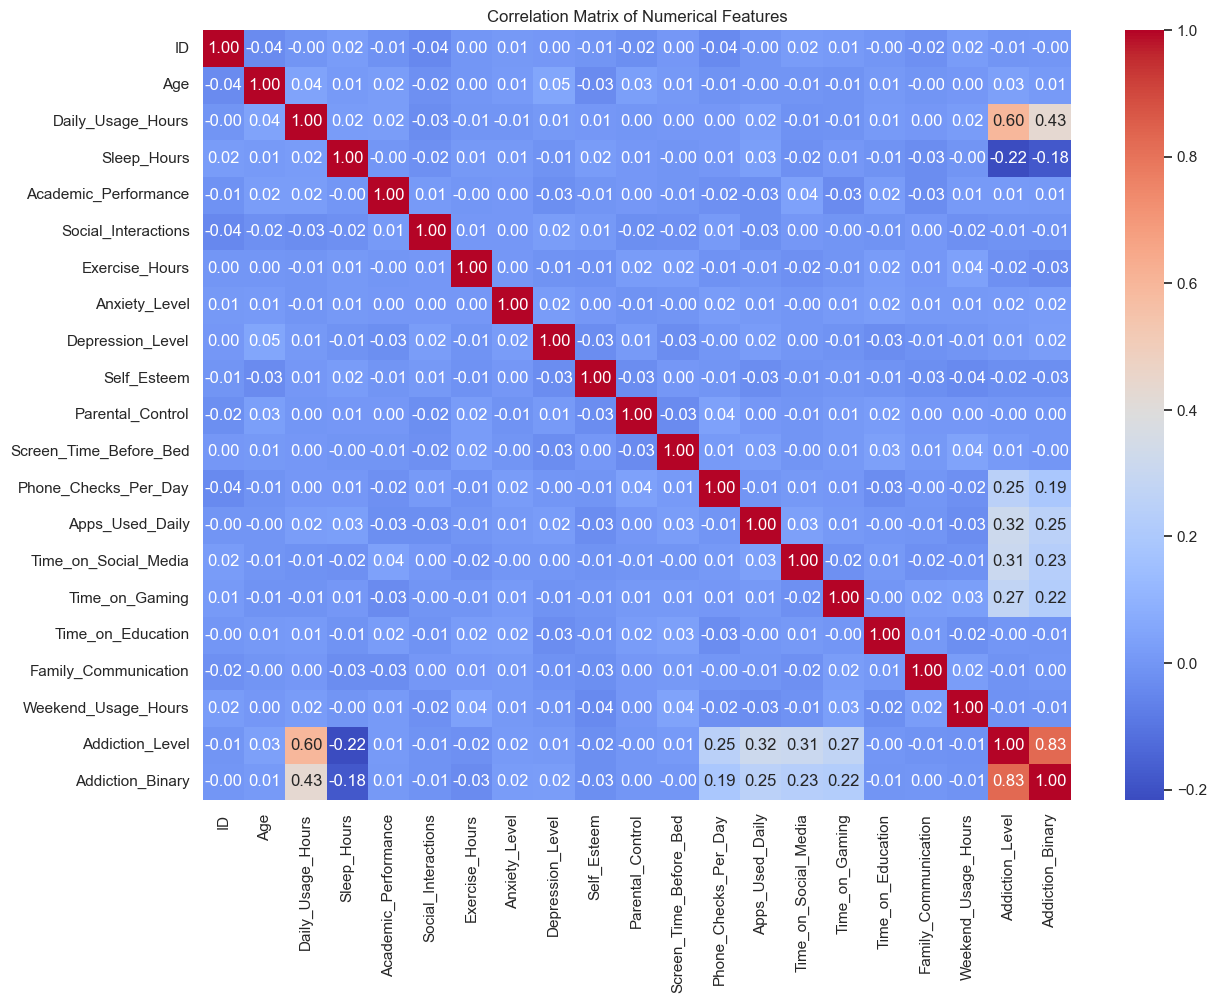

In [61]:
# Correlation heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(data.corr(numeric_only=True), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix of Numerical Features")
plt.show()


In [62]:
# Print correlation with target variable only
correlations = data.corr(numeric_only=True)["Addiction_Binary"].sort_values(ascending=False)
print("Correlation with Addiction_Binary:\n", correlations)


Correlation with Addiction_Binary:
 Addiction_Binary          1.000000
Addiction_Level           0.827273
Daily_Usage_Hours         0.433626
Apps_Used_Daily           0.250108
Time_on_Social_Media      0.232770
Time_on_Gaming            0.221513
Phone_Checks_Per_Day      0.188220
Depression_Level          0.021313
Anxiety_Level             0.017551
Age                       0.013411
Academic_Performance      0.011073
Family_Communication      0.001312
Parental_Control          0.000507
Screen_Time_Before_Bed   -0.001515
ID                       -0.002694
Time_on_Education        -0.005081
Weekend_Usage_Hours      -0.009891
Social_Interactions      -0.009982
Self_Esteem              -0.025988
Exercise_Hours           -0.031971
Sleep_Hours              -0.179956
Name: Addiction_Binary, dtype: float64


In [63]:
# Model Prep:
X = pd.get_dummies(data.drop(["ID", "Name", "Addiction_Level", "Addiction_Binary"], axis=1), drop_first=True)
y = data["Addiction_Binary"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print(y_train_balanced.value_counts())

# Here we start with converting categorical variables to 1's and 0's and storing them in x as features. This is one 
# hot encoding, which allows models to better understand the data. The ID and name column are dropped as they provide 
# no predictive power. Addiction level is removed since we are using low and high categories instead of the number 
# ratings 1-10. Addiction binary is removed as this is the target variable that we need to store in y not in x where 
# the features are. Drop first is set to true to avoid dummy variable trap. Then the data is split into train and test 
# sets, 80% training, 20% testing. Stratify Y esnsures the split maintains the same proportion of high and low 
# addiction levels in both sets. Random state = 42 is for reproducibility. Then SMOTE is applied to balance the training 
# dataset. We then print the value counts of each addiction level to be sure they are the same.

Addiction_Binary
1    2043
0    2043
Name: count, dtype: int64


In [64]:
# Logistic Regression Model
log_reg = LogisticRegression(max_iter=2000)
log_reg.fit(X_train_balanced, y_train_balanced)
predictions_log_reg = log_reg.predict(X_test)

print("Logistic Regression Summary: \n")
print(classification_report(y_test, predictions_log_reg))
print("Adjusted Rand Index: ", round(adjusted_rand_score(y_test, predictions_log_reg), 4))

# Here we initialize the logistic regression model and set max iterations to 2000 to allow more iterations to converge
# in training. This helps with large datasets. Then model training is done using the SMOTE balanced training data. Then the 
# model is used to predict the addiction risk on the unseen test dataset. Then the classification report of the model is 
# outputted. Then the ARI is calculated and outputted. 

Logistic Regression Summary: 

              precision    recall  f1-score   support

           0       0.93      0.98      0.95        89
           1       1.00      0.99      0.99       511

    accuracy                           0.98       600
   macro avg       0.96      0.98      0.97       600
weighted avg       0.99      0.98      0.99       600

Adjusted Rand Index:  0.9229


In [65]:
# Gradient Boosting Model
gboost = GradientBoostingClassifier(random_state=42)
gboost.fit(X_train_balanced, y_train_balanced)
predictions_gboost = gboost.predict(X_test)

print("Gradient Boosting Summary: \n")
print(classification_report(y_test, predictions_gboost))
print("Adjusted Rand Index: ", round(adjusted_rand_score(y_test, predictions_gboost), 4))

# Here we initialize the gradient boosting model. The random state is 42 for reproducibility. Then model training is 
# done using the SMOTE balanced training data. Then the model is used to predict the addiction risk on the unseen test 
# dataset. Then the classification report of the model is outputted. Then the ARI is calculated and outputted. 

Gradient Boosting Summary: 

              precision    recall  f1-score   support

           0       0.85      0.90      0.87        89
           1       0.98      0.97      0.98       511

    accuracy                           0.96       600
   macro avg       0.92      0.94      0.93       600
weighted avg       0.96      0.96      0.96       600

Adjusted Rand Index:  0.8076
